In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests 

In [2]:
#import pickle without zeros 
bg_pkl = open('tempems_bg_pkl_030320', 'rb')

df = pickle.load(bg_pkl)

In [3]:
df.year_month.unique()

array([2018.06, 2019.07, 2017.11, 2018.04, 2018.1 , 2019.05, 2019.08,
       2017.02, 2019.02, 2017.04, 2017.05, 2017.06, 2017.09, 2017.1 ,
       2018.01, 2018.03, 2018.05, 2019.06, 2017.07, 2017.08, 2017.12,
       2018.11, 2018.12, 2019.01, 2019.04, 2018.08, 2017.01, 2018.02,
       2018.09, 2017.03, 2018.07, 2019.03])

### Get Block Group Geometries

In [4]:
import os
os.getcwd()

'/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot'

In [5]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/tl_2019_04_bg')

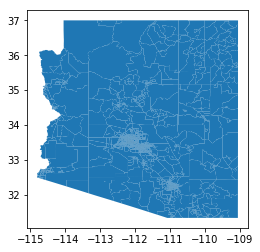

In [6]:
az_bg = gpd.read_file('tl_2019_04_bg.shp')
az_bg.plot()

In [7]:
#city planning data
tempe = gpd.read_file("https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Map/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token=")

In [8]:
#census tract geoids are 11 characters long 
len(tempe['TempeTracts_GEOID'][0])

11

In [9]:
#get list of all tracts in tempe
tracts = tempe['TempeTracts_GEOID']

In [10]:
tracts = pd.DataFrame(tracts)

In [11]:
tracts.head()

,TempeTracts_GEOID
0,04013318800
1,04013319101
2,04013318900
3,04013319000
4,04013319403


In [12]:
tracts.columns

Index(['TempeTracts_GEOID'], dtype='object')

### Pull Geometry and Census Data 

In [13]:
year='2019'
dsource='pdb/blockgroup'
cols='State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,Tract'
state='04'
county='013'
api_key='b76534619ffbdeef7355569c1b9cafd6a55fce2b'

In [14]:
base_url = f'https://api.census.gov/data/{year}/{dsource}'

In [15]:
data_url = f'{base_url}?get={cols}&for=block%20group:*&in=state:{state}&in=county:{county}&in=tract:*&key={api_key}'



In [16]:
response=requests.get(data_url)

In [17]:
data=response.json()
pdb_bg=pd.DataFrame(data[1:], columns=data[0])

In [18]:
pdb_bg.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,Tract,state,county,tract,block group
0,Arizona,Maricopa County,040130101011,1818,49.23,8.36,17.38,47.63,9.74,0.88,...,1.05,"$98,056",5.17,"$600,000",56.51,010101,04,013,010101,1
1,Arizona,Maricopa County,040130101012,1758,48.75,0,10.3,25.03,45.79,3.53,...,0,"$86,518",3.7,"$538,700",56.24,010101,04,013,010101,2
2,Arizona,Maricopa County,040130101013,1339,49.81,0,0,17.92,82.08,0,...,0,"$83,897",2.09,"$479,700",56.83,010101,04,013,010101,3
3,Arizona,Maricopa County,040130101021,978,53.89,0.2,23.31,45.5,28.02,4.29,...,0,"$104,809",4.15,"$476,100",24.6,010102,04,013,010102,1
4,Arizona,Maricopa County,040130101022,1439,53.79,1.25,2.85,42.88,50.8,0,...,8.13,"$95,154",17.44,"$724,300",61.2,010102,04,013,010102,2


In [21]:
pdb_bg['GIDTR'] = pdb_bg.state + pdb_bg.county + pdb_bg.tract

In [22]:
len(pdb_bg['GIDTR'][0])

11

In [23]:
pdb_bg = pdb_bg.merge(tracts, left_on='GIDTR', right_on='TempeTracts_GEOID')

In [25]:
pdb_bg.shape

(109, 24)

In [31]:
az_bg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,013,421702,3,040134217023,Block Group 3,G5030,S,310375,0,+33.4123043,-111.7788867,"POLYGON ((-111.78406 33.41540, -111.78259 33.4..."
1,04,013,040531,2,040130405312,Block Group 2,G5030,S,616061,0,+33.6422660,-112.3722104,"POLYGON ((-112.37679 33.64389, -112.37673 33.6..."
2,04,013,092312,1,040130923121,Block Group 1,G5030,S,295623,0,+33.5654583,-112.1989360,"POLYGON ((-112.20294 33.56672, -112.20293 33.5..."
3,04,019,001000,1,040190010001,Block Group 1,G5030,S,680076,0,+32.2162888,-110.9777138,"POLYGON ((-110.98302 32.21429, -110.98248 32.2..."
4,04,019,001000,2,040190010002,Block Group 2,G5030,S,436369,0,+32.2076281,-110.9763828,"POLYGON ((-110.97941 32.21290, -110.97941 32.2..."


In [32]:
temp = pdb_bg.merge(az_bg, left_on='GIDBG', right_on='GEOID')

In [33]:
temp.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,Arizona,Maricopa County,040133184003,1021,52.5,7.84,42.41,25.66,6.86,54.46,...,3,040133184003,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,"POLYGON ((-111.92643 33.44398, -111.92636 33.4..."
1,Arizona,Maricopa County,040133184001,2307,52.19,15.08,46.29,8.15,6.98,55.57,...,1,040133184001,Block Group 1,G5030,S,635617,0,+33.4476431,-111.9221824,"POLYGON ((-111.92646 33.45125, -111.92548 33.4..."
2,Arizona,Maricopa County,040133184002,1808,58.9,26.83,40.04,22.79,1.22,28.98,...,2,040133184002,Block Group 2,G5030,S,6105549,156123,+33.4311846,-111.9069608,"POLYGON ((-111.92633 33.44029, -111.92580 33.4..."
3,Arizona,Maricopa County,040133185011,1909,40.18,9.8,29.7,27.55,16.03,27.76,...,1,040133185011,Block Group 1,G5030,S,455164,0,+33.4558912,-111.9307318,"POLYGON ((-111.93513 33.45398, -111.93511 33.4..."
4,Arizona,Maricopa County,040133185012,1111,51.4,14.76,59.14,16.38,6.03,31.23,...,2,040133185012,Block Group 2,G5030,S,196182,0,+33.4522630,-111.9308120,"POLYGON ((-111.93519 33.45151, -111.93518 33.4..."


In [35]:
temp = gpd.GeoDataFrame(temp, geometry=temp.geometry)

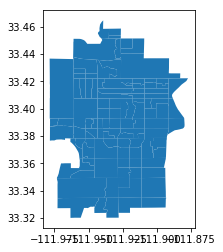

In [36]:
temp.plot()

### Get EMS calls

In [37]:
### create shell dataframe for the years
years = [2017, 2018, 2019, 2020]
months = np.arange(.01,.13,.01)

In [38]:
#get list of all possible years
year_month = []
for i in range(len(years)):
    for j in range(len(months)):
        ym = years[i] + months[j]
        year_month.append(ym)

In [39]:
len(year_month)

48

In [40]:
temp.shape

(109, 37)

In [41]:
tempy = pd.DataFrame()
temp['year_month'] = 0
for i in range(len(year_month)):
    temp['year_month'] = year_month[i]
    tempy = pd.concat([tempy, temp], axis = 0)

In [44]:
tempy.shape

(5232, 38)

In [45]:
### check that it copied the df for each year_month
109*len(year_month)

5232

In [48]:
df.ems_calls.describe()

count    534.000000
mean       1.264045
std        0.596691
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: ems_calls, dtype: float64

In [49]:
tempy.GIDBG = tempy.GIDBG.astype(float)

In [50]:
tempy.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,year_month
0,Arizona,Maricopa County,4.013318e+10,1021,52.5,7.84,42.41,25.66,6.86,54.46,...,040133184003,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,"POLYGON ((-111.92643 33.44398, -111.92636 33.4...",2017.01
1,Arizona,Maricopa County,4.013318e+10,2307,52.19,15.08,46.29,8.15,6.98,55.57,...,040133184001,Block Group 1,G5030,S,635617,0,+33.4476431,-111.9221824,"POLYGON ((-111.92646 33.45125, -111.92548 33.4...",2017.01
2,Arizona,Maricopa County,4.013318e+10,1808,58.9,26.83,40.04,22.79,1.22,28.98,...,040133184002,Block Group 2,G5030,S,6105549,156123,+33.4311846,-111.9069608,"POLYGON ((-111.92633 33.44029, -111.92580 33.4...",2017.01
3,Arizona,Maricopa County,4.013319e+10,1909,40.18,9.8,29.7,27.55,16.03,27.76,...,040133185011,Block Group 1,G5030,S,455164,0,+33.4558912,-111.9307318,"POLYGON ((-111.93513 33.45398, -111.93511 33.4...",2017.01
4,Arizona,Maricopa County,4.013319e+10,1111,51.4,14.76,59.14,16.38,6.03,31.23,...,040133185012,Block Group 2,G5030,S,196182,0,+33.4522630,-111.9308120,"POLYGON ((-111.93519 33.45151, -111.93518 33.4...",2017.01


In [51]:
ems = df.filter(['GIDBG', 'ems_calls', 'year_month'])

In [52]:
ems.head()

,GIDBG,ems_calls,year_month
0,4.013319e+10,1,2018.06
1,4.013319e+10,1,2019.07
2,4.013319e+10,1,2017.11
3,4.013319e+10,1,2018.04
4,4.013319e+10,1,2018.10


In [53]:
full = tempy.merge(ems, on=['GIDBG', 'year_month'], how='left')

In [54]:
full.shape

(5232, 39)

In [55]:
full.ems_calls.replace(np.NaN, 0, inplace=True)

In [56]:
full.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,year_month,ems_calls
0,Arizona,Maricopa County,4.013318e+10,1021,52.5,7.84,42.41,25.66,6.86,54.46,...,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,"POLYGON ((-111.92643 33.44398, -111.92636 33.4...",2017.01,0.0
1,Arizona,Maricopa County,4.013318e+10,2307,52.19,15.08,46.29,8.15,6.98,55.57,...,Block Group 1,G5030,S,635617,0,+33.4476431,-111.9221824,"POLYGON ((-111.92646 33.45125, -111.92548 33.4...",2017.01,1.0
2,Arizona,Maricopa County,4.013318e+10,1808,58.9,26.83,40.04,22.79,1.22,28.98,...,Block Group 2,G5030,S,6105549,156123,+33.4311846,-111.9069608,"POLYGON ((-111.92633 33.44029, -111.92580 33.4...",2017.01,2.0
3,Arizona,Maricopa County,4.013319e+10,1909,40.18,9.8,29.7,27.55,16.03,27.76,...,Block Group 1,G5030,S,455164,0,+33.4558912,-111.9307318,"POLYGON ((-111.93513 33.45398, -111.93511 33.4...",2017.01,0.0
4,Arizona,Maricopa County,4.013319e+10,1111,51.4,14.76,59.14,16.38,6.03,31.23,...,Block Group 2,G5030,S,196182,0,+33.4522630,-111.9308120,"POLYGON ((-111.93519 33.45151, -111.93518 33.4...",2017.01,0.0


In [57]:
sum(full.ems_calls)

675.0

In [58]:
#these should match
#df was created by just grabbing block groups with >=1 ems calls in it
#full includes all bg over the timeperiod, including the zeros
df.ems_calls.sum()

675

In [59]:
#test monthly totals to see where we don't have data
#looks like we don't have anything past february 2020
full.groupby('year_month').sum()

,GIDBG,ALAND,AWATER,ems_calls
year_month,,,,
2017.01,4.374543e+12,104386519,717889,21.0
2017.02,4.374543e+12,104386519,717889,24.0
2017.03,4.374543e+12,104386519,717889,22.0
2017.04,4.374543e+12,104386519,717889,34.0
2017.05,4.374543e+12,104386519,717889,29.0
2017.06,4.374543e+12,104386519,717889,30.0
2017.07,4.374543e+12,104386519,717889,39.0
2017.08,4.374543e+12,104386519,717889,24.0
2017.09,4.374543e+12,104386519,717889,16.0


In [60]:
full.sort_values(by='year_month', inplace=True)

In [61]:
#there are 12*2 + 9 = 33 months from 2017 to February 2020
#109 block groups per year month in the sample
#so can cut off after the 38*109 value when sorted by year_month
109*33


3597

In [64]:
#cutoff at 3597
full.year_month[3594:3598]

3518    2019.09
3517    2019.09
3528    2019.09
3667    2019.10
Name: year_month, dtype: float64

In [65]:
full = full[:3597]

In [66]:
full.year_month.unique()

array([2017.01, 2017.02, 2017.03, 2017.04, 2017.05, 2017.06, 2017.07,
       2017.08, 2017.09, 2017.1 , 2017.11, 2017.12, 2018.01, 2018.02,
       2018.03, 2018.04, 2018.05, 2018.06, 2018.07, 2018.08, 2018.09,
       2018.1 , 2018.11, 2018.12, 2019.01, 2019.02, 2019.03, 2019.04,
       2019.05, 2019.06, 2019.07, 2019.08, 2019.09])

In [67]:
full.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,year_month,ems_calls
0,Arizona,Maricopa County,4.013318e+10,1021,52.5,7.84,42.41,25.66,6.86,54.46,...,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,"POLYGON ((-111.92643 33.44398, -111.92636 33.4...",2017.01,0.0
79,Arizona,Maricopa County,4.013320e+10,2052,60.43,16.81,31.04,27.78,8.82,16.37,...,Block Group 1,G5030,S,629464,0,+33.3602444,-111.9242366,"POLYGON ((-111.92860 33.36375, -111.92693 33.3...",2017.01,0.0
78,Arizona,Maricopa County,4.013320e+10,2180,36.83,3.21,30.78,15.05,14.95,36.47,...,Block Group 4,G5030,S,588943,69476,+33.3749019,-111.9171999,"POLYGON ((-111.92049 33.37832, -111.91869 33.3...",2017.01,0.0
77,Arizona,Maricopa County,4.013320e+10,1234,59.81,8.1,25.77,39.38,6.97,33.39,...,Block Group 2,G5030,S,687503,0,+33.3676045,-111.9155107,"POLYGON ((-111.91995 33.37123, -111.91939 33.3...",2017.01,0.0
76,Arizona,Maricopa County,4.013320e+10,2054,47.96,16.16,39.78,22.25,10.52,12.07,...,Block Group 1,G5030,S,530171,112995,+33.3752116,-111.9197726,"POLYGON ((-111.92868 33.37826, -111.92659 33.3...",2017.01,0.0


In [68]:
full.dtypes

State_name                         object
County_name                        object
GIDBG                             float64
Tot_Population_ACS_13_17           object
pct_Males_ACS_13_17                object
pct_Pop_18_24_ACS_13_17            object
pct_Pop_25_44_ACS_13_17            object
pct_Pop_45_64_ACS_13_17            object
pct_Pop_65plus_ACS_13_17           object
pct_Hispanic_ACS_13_17             object
pct_NH_White_alone_CEN_2010        object
pct_NH_Blk_alone_ACS_13_17         object
pct_NH_Asian_alone_ACS_13_17       object
Med_HHD_Inc_BG_ACS_13_17           object
pct_Prs_Blw_Pov_Lev_ACS_13_17      object
Med_House_Value_BG_ACS_13_17       object
pct_College_ACS_13_17              object
Tract                              object
state                              object
county                             object
tract                              object
block group                        object
GIDTR                              object
TempeTracts_GEOID                 

In [69]:
full.Med_HHD_Inc_BG_ACS_13_17.head()

0     $50,931
79    $58,443
78    $65,515
77    $79,342
76    $70,942
Name: Med_HHD_Inc_BG_ACS_13_17, dtype: object

#### Data Cleaning

In [70]:
full['Med_HHD_Inc_BG_ACS_13_17'] = full['Med_HHD_Inc_BG_ACS_13_17'].str.replace('$', '')
full['Med_HHD_Inc_BG_ACS_13_17'] = full['Med_HHD_Inc_BG_ACS_13_17'].str.replace(',', '')
full['Med_House_Value_BG_ACS_13_17'] = full['Med_House_Value_BG_ACS_13_17'].str.replace('$', '')
full['Med_House_Value_BG_ACS_13_17'] = full['Med_House_Value_BG_ACS_13_17'].str.replace(',', '')

In [71]:
full.dtypes

State_name                         object
County_name                        object
GIDBG                             float64
Tot_Population_ACS_13_17           object
pct_Males_ACS_13_17                object
pct_Pop_18_24_ACS_13_17            object
pct_Pop_25_44_ACS_13_17            object
pct_Pop_45_64_ACS_13_17            object
pct_Pop_65plus_ACS_13_17           object
pct_Hispanic_ACS_13_17             object
pct_NH_White_alone_CEN_2010        object
pct_NH_Blk_alone_ACS_13_17         object
pct_NH_Asian_alone_ACS_13_17       object
Med_HHD_Inc_BG_ACS_13_17           object
pct_Prs_Blw_Pov_Lev_ACS_13_17      object
Med_House_Value_BG_ACS_13_17       object
pct_College_ACS_13_17              object
Tract                              object
state                              object
county                             object
tract                              object
block group                        object
GIDTR                              object
TempeTracts_GEOID                 

In [72]:
#convert to floats 
col = full.columns[3:17]
for i in range(len(col)):
    full[col[i]] = full[col[i]].astype(float)

In [73]:
full.dtypes

State_name                         object
County_name                        object
GIDBG                             float64
Tot_Population_ACS_13_17          float64
pct_Males_ACS_13_17               float64
pct_Pop_18_24_ACS_13_17           float64
pct_Pop_25_44_ACS_13_17           float64
pct_Pop_45_64_ACS_13_17           float64
pct_Pop_65plus_ACS_13_17          float64
pct_Hispanic_ACS_13_17            float64
pct_NH_White_alone_CEN_2010       float64
pct_NH_Blk_alone_ACS_13_17        float64
pct_NH_Asian_alone_ACS_13_17      float64
Med_HHD_Inc_BG_ACS_13_17          float64
pct_Prs_Blw_Pov_Lev_ACS_13_17     float64
Med_House_Value_BG_ACS_13_17      float64
pct_College_ACS_13_17             float64
Tract                              object
state                              object
county                             object
tract                              object
block group                        object
GIDTR                              object
TempeTracts_GEOID                 

In [74]:
full = full.select_dtypes(exclude=['object', 'int64'])

In [75]:
full['log_pop'] = np.log(full.Tot_Population_ACS_13_17)

In [76]:
#put into $100,000
full.Med_HHD_Inc_BG_ACS_13_17 = full.Med_HHD_Inc_BG_ACS_13_17/100000

In [77]:
full.Med_House_Value_BG_ACS_13_17 = full.Med_House_Value_BG_ACS_13_17/1000000

In [78]:
#scale percentage variables 
scl = ['pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','pct_College_ACS_13_17']

for i in range(len(scl)):
    full[scl[i]] = full[scl[i]]/100

In [79]:
full.head()

,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,geometry,year_month,ems_calls,log_pop
0,4.013318e+10,1021.0,0.5250,0.0784,0.4241,0.2566,0.0686,0.5446,0.3700,0.0539,0.0000,0.50931,0.1704,0.1833,0.2497,"POLYGON ((-111.92643 33.44398, -111.92636 33.4...",2017.01,0.0,6.928538
79,4.013320e+10,2052.0,0.6043,0.1681,0.3104,0.2778,0.0882,0.1637,0.6777,0.0000,0.0180,0.58443,0.2368,0.1779,0.3465,"POLYGON ((-111.92860 33.36375, -111.92693 33.3...",2017.01,0.0,7.626570
78,4.013320e+10,2180.0,0.3683,0.0321,0.3078,0.1505,0.1495,0.3647,0.7841,0.0257,0.0647,0.65515,0.0335,0.2861,0.5298,"POLYGON ((-111.92049 33.37832, -111.91869 33.3...",2017.01,0.0,7.687080
77,4.013320e+10,1234.0,0.5981,0.0810,0.2577,0.3938,0.0697,0.3339,0.7384,0.0000,0.0000,0.79342,0.0235,0.2920,0.4494,"POLYGON ((-111.91995 33.37123, -111.91939 33.3...",2017.01,0.0,7.118016
76,4.013320e+10,2054.0,0.4796,0.1616,0.3978,0.2225,0.1052,0.1207,0.6378,0.0073,0.0983,0.70942,0.0933,0.3203,0.5919,"POLYGON ((-111.92868 33.37826, -111.92659 33.3...",2017.01,0.0,7.627544


In [80]:
full.drop('Tot_Population_ACS_13_17', axis=1, inplace=True)

In [81]:
full.head()

,GIDBG,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,geometry,year_month,ems_calls,log_pop
0,4.013318e+10,0.5250,0.0784,0.4241,0.2566,0.0686,0.5446,0.3700,0.0539,0.0000,0.50931,0.1704,0.1833,0.2497,"POLYGON ((-111.92643 33.44398, -111.92636 33.4...",2017.01,0.0,6.928538
79,4.013320e+10,0.6043,0.1681,0.3104,0.2778,0.0882,0.1637,0.6777,0.0000,0.0180,0.58443,0.2368,0.1779,0.3465,"POLYGON ((-111.92860 33.36375, -111.92693 33.3...",2017.01,0.0,7.626570
78,4.013320e+10,0.3683,0.0321,0.3078,0.1505,0.1495,0.3647,0.7841,0.0257,0.0647,0.65515,0.0335,0.2861,0.5298,"POLYGON ((-111.92049 33.37832, -111.91869 33.3...",2017.01,0.0,7.687080
77,4.013320e+10,0.5981,0.0810,0.2577,0.3938,0.0697,0.3339,0.7384,0.0000,0.0000,0.79342,0.0235,0.2920,0.4494,"POLYGON ((-111.91995 33.37123, -111.91939 33.3...",2017.01,0.0,7.118016
76,4.013320e+10,0.4796,0.1616,0.3978,0.2225,0.1052,0.1207,0.6378,0.0073,0.0983,0.70942,0.0933,0.3203,0.5919,"POLYGON ((-111.92868 33.37826, -111.92659 33.3...",2017.01,0.0,7.627544


In [83]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/')
pickle_out = open("tempems_bg_pkl_030820","wb")
pickle.dump(full, pickle_out)
pickle_out.close()

### Descriptive Statistics

In [84]:
bg_pkl = open('tempems_bg_pkl_030820', 'rb')

df = pickle.load(bg_pkl)

In [85]:
df.ems_calls.describe()

count    3597.000000
mean        0.187656
std         0.504797
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: ems_calls, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2381c978>,
      dtype=object)

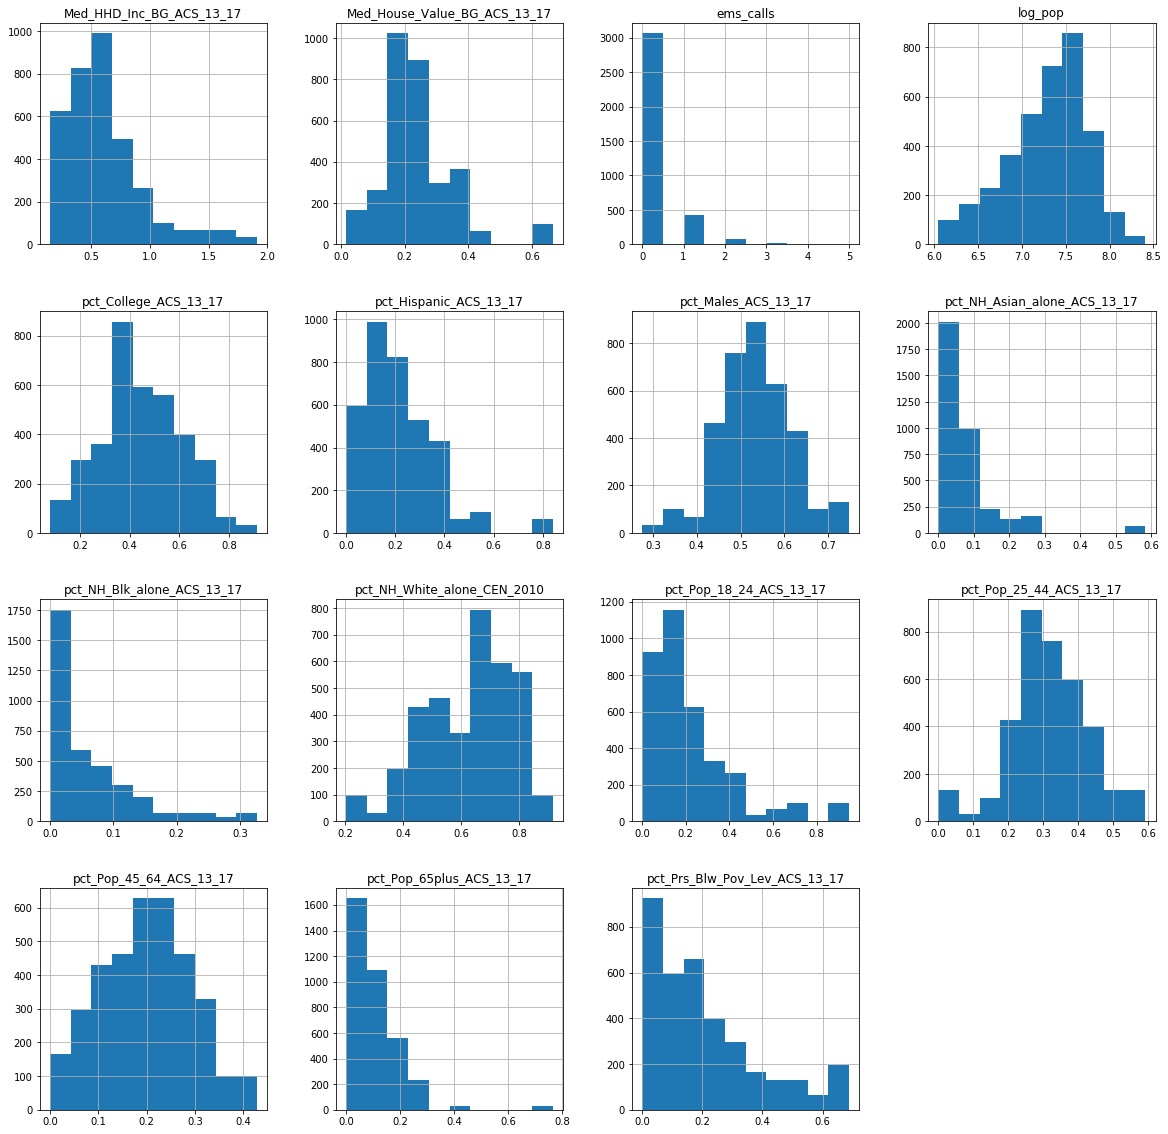

In [86]:
hist = df.drop(columns=['GIDBG', 'year_month'], axis=1)
hist.hist(figsize=(20,20))

In [87]:
desc = hist.describe().T
desc = desc.filter(['mean', 'std'])
desc[1:]

,mean,std
pct_Pop_18_24_ACS_13_17,0.223194,0.194378
pct_Pop_25_44_ACS_13_17,0.315598,0.109953
pct_Pop_45_64_ACS_13_17,0.201550,0.093496
pct_Pop_65plus_ACS_13_17,0.107331,0.098961
pct_Hispanic_ACS_13_17,0.216689,0.147716
pct_NH_White_alone_CEN_2010,0.626721,0.153300
pct_NH_Blk_alone_ACS_13_17,0.060712,0.070117
pct_NH_Asian_alone_ACS_13_17,0.073111,0.092551
Med_HHD_Inc_BG_ACS_13_17,0.606538,0.332328
pct_Prs_Blw_Pov_Lev_ACS_13_17,0.208851,0.178831


In [88]:
#check dispersion --> evidence of over dispersion if var>mean
ems_var = hist.ems_calls.std()**2
print('ems call mean :', hist.ems_calls.mean(), 'ems_call var :', ems_var)

ems call mean : 0.18765638031693077 ems_call var : 0.25481978400612304


In [89]:
sum(df.ems_calls)

675.0

Text(0.5, 1.0, 'Histogram EMS Calls in Cincinnati 2017.01-2020.02')

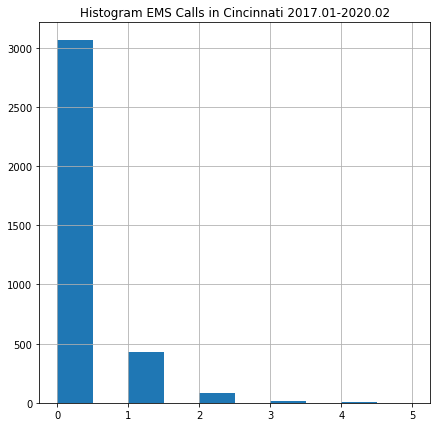

In [90]:
df.ems_calls.hist(figsize=(7,7))
plt.title('Histogram EMS Calls in Cincinnati 2017.01-2020.02')

In [91]:
df.ems_calls.describe().T

count    3597.000000
mean        0.187656
std         0.504797
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: ems_calls, dtype: float64

### High-Lo Analysis 

In [92]:
hi = df[df['ems_calls']>1]
lo = df[df['ems_calls']<=1]


In [93]:
lo.ems_calls.describe()

count    3489.000000
mean        0.122098
std         0.327446
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: ems_calls, dtype: float64

In [94]:
hi.ems_calls.describe()

count    108.000000
mean       2.305556
std        0.633317
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: ems_calls, dtype: float64

In [95]:
hi.head()

,GIDBG,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,geometry,year_month,ems_calls,log_pop
63,4.013320e+10,0.5818,0.1878,0.3957,0.1891,0.0778,0.3544,0.5543,0.0261,0.1094,0.56250,0.1951,0.1720,0.4450,"POLYGON ((-111.97850 33.43652, -111.97804 33.4...",2017.01,2.0,7.405496
2,4.013318e+10,0.5890,0.2683,0.4004,0.2279,0.0122,0.2898,0.5623,0.0000,0.1062,0.35707,0.3927,0.0463,0.2737,"POLYGON ((-111.92633 33.44029, -111.92580 33.4...",2017.01,2.0,7.499977
40,4.013319e+10,0.4663,0.2521,0.2667,0.1771,0.1372,0.3396,0.4467,0.0927,0.0715,0.23507,0.3650,0.1105,0.1560,"POLYGON ((-111.89152 33.41373, -111.89152 33.4...",2017.01,4.0,7.965546
183,4.013320e+10,0.4747,0.1815,0.2289,0.1831,0.2594,0.3277,0.6680,0.0956,0.0305,0.64219,0.1624,0.1701,0.3134,"POLYGON ((-111.94598 33.37710, -111.94596 33.3...",2017.02,2.0,7.126891
135,4.013319e+10,0.4667,0.6986,0.1361,0.1168,0.0463,0.1664,0.5139,0.0264,0.0920,0.16654,0.6331,0.0532,0.2357,"POLYGON ((-111.92628 33.41367, -111.92629 33.4...",2017.02,2.0,7.503841


#### Lo-Classification

In [96]:
lo.ems_calls.value_counts()

0.0    3063
1.0     426
Name: ems_calls, dtype: int64

In [97]:
lo.head()

,GIDBG,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,geometry,year_month,ems_calls,log_pop
0,4.013318e+10,0.5250,0.0784,0.4241,0.2566,0.0686,0.5446,0.3700,0.0539,0.0000,0.50931,0.1704,0.1833,0.2497,"POLYGON ((-111.92643 33.44398, -111.92636 33.4...",2017.01,0.0,6.928538
79,4.013320e+10,0.6043,0.1681,0.3104,0.2778,0.0882,0.1637,0.6777,0.0000,0.0180,0.58443,0.2368,0.1779,0.3465,"POLYGON ((-111.92860 33.36375, -111.92693 33.3...",2017.01,0.0,7.626570
78,4.013320e+10,0.3683,0.0321,0.3078,0.1505,0.1495,0.3647,0.7841,0.0257,0.0647,0.65515,0.0335,0.2861,0.5298,"POLYGON ((-111.92049 33.37832, -111.91869 33.3...",2017.01,0.0,7.687080
77,4.013320e+10,0.5981,0.0810,0.2577,0.3938,0.0697,0.3339,0.7384,0.0000,0.0000,0.79342,0.0235,0.2920,0.4494,"POLYGON ((-111.91995 33.37123, -111.91939 33.3...",2017.01,0.0,7.118016
76,4.013320e+10,0.4796,0.1616,0.3978,0.2225,0.1052,0.1207,0.6378,0.0073,0.0983,0.70942,0.0933,0.3203,0.5919,"POLYGON ((-111.92868 33.37826, -111.92659 33.3...",2017.01,0.0,7.627544


In [98]:
lo.dropna(inplace=True)
X_lo, y_lo = lo, lo.ems_calls
X_lo.drop(['GIDBG', 'geometry', 'year_month', 'ems_calls'], axis=1, inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lo, y_lo, test_size=0.2, random_state=42)

In [100]:
mod = sm.Logit(y_train, X_train)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.357497
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              ems_calls   No. Observations:                 2428
Model:                          Logit   Df Residuals:                     2414
Method:                           MLE   Df Model:                           13
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                 0.04194
Time:                        18:55:43   Log-Likelihood:                -868.00
converged:                       True   LL-Null:                       -906.00
                                        LLR p-value:                 6.191e-11
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_13_17               2.2735      0.918      2.477      0.013       0.475       4.073
pct_Pop_18_24_ACS_13_17          -1.3576      0.851     -1.596      0.110      -3.025       0.310
pct_Pop_25_44_ACS_13_17          -4.1249      1.006     -4.098      0.000      -6.098      -2.152
pct_Pop_45_64_ACS_13_17          -3.1934      1.298     -2.460      0.014      -5.738      -0.649
pct_Pop_65plus_ACS_13_17         -3.5647      1.208     -2.950      0.003      -5.933      -1.196
pct_Hispanic_ACS_13_17            0.4567      0.644      0.709      0.478      -0.805       1.719
pct_NH_White_alone_CEN_2010       0.3353      0.923      0.363      0.716      -1.473       2.144
pct_NH_Blk_alone_ACS_13_17        0.5720      1.159      0.494      0.622      -1.699       2.843
pct_NH_Asian_alone_ACS_13_17     -1.5461      1.041     -1.485      0.138      -3.587       0.495
Med_HHD_Inc_BG_ACS_13_17          0.3736      0.330      1.131      0.258      -0.274       1.021
pct_Prs_Blw_Pov_Lev_ACS_13_17     1.4530      0.730      1.991      0.046       0.023       2.883
Med_House_Value_BG_ACS_13_17     -3.3338      0.995     -3.350      0.001      -5.284      -1.384
pct_College_ACS_13_17             1.2240      0.611      2.002      0.045       0.026       2.422
log_pop                          -0.1552      0.108     -1.432      0.152      -0.368       0.057
=================================================================================================
"""

In [ ]:
'''
DG Notes 030820: 

Statistically significant regressors are percent male(+), percent population 25-44(-), percent population 45-64(-),
percent population 65 plus (-), percent below poverty level (+), median house value (-), percent college(+)


Calls now decrease with house value, as opposed to incresing as they do in Tempe. Racial covariates 
seem to have no bearing here, while age ones do. Percent male shows up statistically significant here surprisingly?

pseudo r2 is still incredibly low. Is this just because we're looking at noise and imbalanced classes?
Model performs poorly
'''

In [ ]:
#### Try other classifiers? Pseudo r2 sucks?

#### Hi-Analysis

In [101]:
hi.dropna(inplace=True)
X_hi, y_hi = hi, hi.ems_calls
X_hi.drop(['GIDBG', 'geometry', 'year_month', 'ems_calls'], axis=1, inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_hi, y_hi, test_size=0.2, random_state=42)

In [103]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ems_calls   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     78.79
Date:                Sun, 08 Mar 2020   Prob (F-statistic):           1.49e-35
Time:                        18:59:05   Log-Likelihood:                -70.465
No. Observations:                  80   AIC:                             168.9
Df Residuals:                      66   BIC:                             202.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_13_17               0.1165      1.438      0.081      0.936      -2.754       2.987
pct_Pop_18_24_ACS_13_17           1.3983      1.415      0.988      0.327      -1.427       4.224
pct_Pop_25_44_ACS_13_17           1.4125      1.648      0.857      0.395      -1.878       4.703
pct_Pop_45_64_ACS_13_17           1.6368      2.003      0.817      0.417      -2.363       5.637
pct_Pop_65plus_ACS_13_17          0.8242      2.113      0.390      0.698      -3.394       5.042
pct_Hispanic_ACS_13_17            0.1272      1.142      0.111      0.912      -2.153       2.408
pct_NH_White_alone_CEN_2010       0.3816      1.479      0.258      0.797      -2.572       3.335
pct_NH_Blk_alone_ACS_13_17       -1.1530      3.228     -0.357      0.722      -7.597       5.291
pct_NH_Asian_alone_ACS_13_17      0.4256      1.793      0.237      0.813      -3.155       4.006
Med_HHD_Inc_BG_ACS_13_17          0.1594      0.415      0.384      0.702      -0.669       0.988
pct_Prs_Blw_Pov_Lev_ACS_13_17     0.9228      1.273      0.725      0.471      -1.619       3.465
Med_House_Value_BG_ACS_13_17     -2.9555      2.039     -1.450      0.152      -7.026       1.115
pct_College_ACS_13_17             0.7455      1.274      0.585      0.560      -1.798       3.289
log_pop                           0.1012      0.208      0.486      0.629      -0.315       0.517
==============================================================================
Omnibus:                       32.297   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.343
Skew:                           1.508   Prob(JB):                     2.90e-14
Kurtosis:                       6.099   Cond. No.                         414.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
'''
DG Notes 030820: 

No statistically significant regressors here. Could be a function of sample size? 

'''

In [105]:
#try poisson
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ems_calls   No. Observations:                   80
Model:                            GLM   Df Residuals:                       66
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -114.39
Date:                Sun, 08 Mar 2020   Deviance:                       9.5686
Time:                        19:07:45   Pearson chi2:                     10.4
No. Iterations:                     4   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_13_17              -0.0333      1.487     -0.022      0.982      -2.947       2